# Tennessee Eastman Process Simulator - Introduction

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jkitchin/tennessee-eastman-profbraatz/blob/master/examples/introduction.ipynb)

This notebook provides an introduction to the Tennessee Eastman Process (TEP) simulator, demonstrating:

1. Basic fault-free simulation
2. Simulation with a fault and visualization of measurement changes
3. Using closed-loop control
4. Simple fault detection (for illustration purposes)

The TEP is a widely-used benchmark for process control and fault detection research, simulating a realistic chemical process with a reactor, separator, stripper, and compressor.

In [1]:
# Uncomment and run this cell to install the package in Google Colab
# !pip install git+https://github.com/jkitchin/tennessee-eastman-profbraatz

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tep import TEPSimulator, DISTURBANCE_NAMES, MEASUREMENT_NAMES
from tep.simulator import ControlMode

## 1. Basic Fault-Free Simulation

Let's start with a simple simulation under normal operating conditions. The TEP simulator runs in closed-loop mode by default, with decentralized PI controllers maintaining stable operation.

In [3]:
# Create simulator with a fixed random seed for reproducibility
sim = TEPSimulator(random_seed=12345, control_mode=ControlMode.CLOSED_LOOP)

# Initialize to steady state
sim.initialize()

# Check initial conditions
xmeas = sim.get_measurements()
print("Initial Conditions:")
print(f"  Reactor Temperature: {xmeas[8]:.1f} °C")
print(f"  Reactor Pressure:    {xmeas[6]:.1f} kPa")
print(f"  Reactor Level:       {xmeas[7]:.1f} %")

Initial Conditions:
  Reactor Temperature: 120.4 °C
  Reactor Pressure:    2705.0 kPa
  Reactor Level:       75.0 %


In [4]:
# Run a 2-hour simulation with no faults
result = sim.simulate(
    duration_hours=2.0,
    record_interval=60  # Record every 60 seconds
)

print(f"Simulation completed!")
print(f"  Duration: {result.time[-1]:.2f} hours")
print(f"  Data points: {len(result.time)}")
print(f"  Shutdown: {result.shutdown}")

Simulation completed!
  Duration: 2.00 hours
  Data points: 121
  Shutdown: False


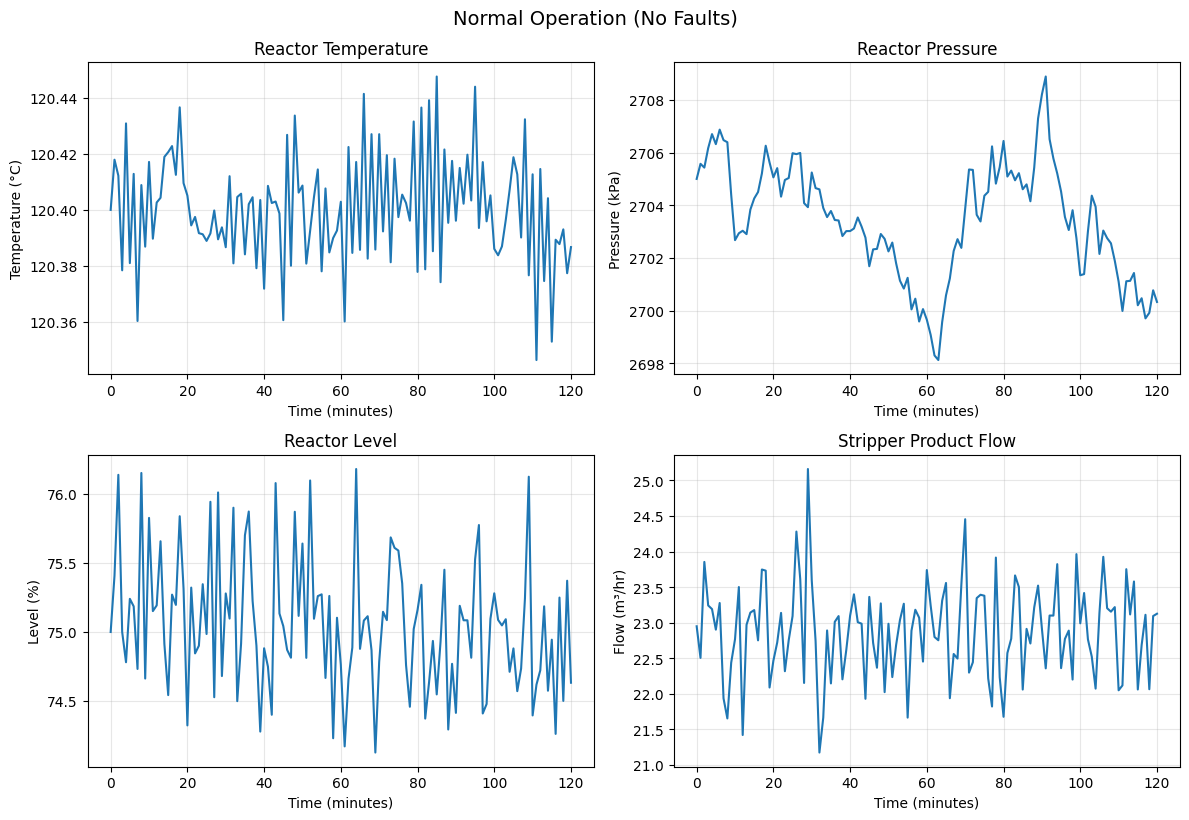

In [5]:
# Plot key process variables during normal operation
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Reactor temperature
axes[0, 0].plot(result.time_minutes, result.measurements[:, 8])
axes[0, 0].set_xlabel('Time (minutes)')
axes[0, 0].set_ylabel('Temperature (°C)')
axes[0, 0].set_title('Reactor Temperature')
axes[0, 0].grid(True, alpha=0.3)

# Reactor pressure
axes[0, 1].plot(result.time_minutes, result.measurements[:, 6])
axes[0, 1].set_xlabel('Time (minutes)')
axes[0, 1].set_ylabel('Pressure (kPa)')
axes[0, 1].set_title('Reactor Pressure')
axes[0, 1].grid(True, alpha=0.3)

# Reactor level
axes[1, 0].plot(result.time_minutes, result.measurements[:, 7])
axes[1, 0].set_xlabel('Time (minutes)')
axes[1, 0].set_ylabel('Level (%)')
axes[1, 0].set_title('Reactor Level')
axes[1, 0].grid(True, alpha=0.3)

# Product flow
axes[1, 1].plot(result.time_minutes, result.measurements[:, 16])
axes[1, 1].set_xlabel('Time (minutes)')
axes[1, 1].set_ylabel('Flow (m³/hr)')
axes[1, 1].set_title('Stripper Product Flow')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Normal Operation (No Faults)', y=1.02, fontsize=14)
plt.show()

## 2. Simulation with a Fault

The TEP includes 20 pre-programmed process disturbances (faults). Let's simulate **IDV(4): Reactor Cooling Water Inlet Temperature Step Change**, which is one of the easier faults to detect.

First, let's see what faults are available:

In [6]:
# Show available disturbances
print("Available Process Disturbances (Faults):")
print("=" * 60)
for i, name in enumerate(DISTURBANCE_NAMES[:15], 1):
    print(f"  IDV({i:2d}): {name}")
print("  ...")
print(f"  IDV(16-20): Unknown (reserved for testing)")

Available Process Disturbances (Faults):
  IDV( 1): A/C Feed Ratio, B Composition Constant (Step)
  IDV( 2): B Composition, A/C Ratio Constant (Step)
  IDV( 3): D Feed Temperature (Step)
  IDV( 4): Reactor Cooling Water Inlet Temperature (Step)
  IDV( 5): Condenser Cooling Water Inlet Temperature (Step)
  IDV( 6): A Feed Loss (Step)
  IDV( 7): C Header Pressure Loss (Step)
  IDV( 8): A, B, C Feed Composition (Random Variation)
  IDV( 9): D Feed Temperature (Random Variation)
  IDV(10): C Feed Temperature (Random Variation)
  IDV(11): Reactor Cooling Water Inlet Temp (Random Variation)
  IDV(12): Condenser Cooling Water Inlet Temp (Random Var)
  IDV(13): Reaction Kinetics (Slow Drift)
  IDV(14): Reactor Cooling Water Valve (Sticking)
  IDV(15): Condenser Cooling Water Valve (Sticking)
  ...
  IDV(16-20): Unknown (reserved for testing)


In [7]:
# Create a new simulator and run with fault IDV(4)
sim = TEPSimulator(random_seed=12345, control_mode=ControlMode.CLOSED_LOOP)
sim.initialize()

# Simulate for 4 hours, with fault starting at t=1 hour
result_fault = sim.simulate(
    duration_hours=4.0,
    disturbances={4: (1.0, 1)},  # IDV(4) activates at t=1 hour
    record_interval=60
)

print(f"Simulation with IDV(4) completed!")
print(f"  Fault: {DISTURBANCE_NAMES[3]}")
print(f"  Fault onset: 1.0 hours")
print(f"  Shutdown: {result_fault.shutdown}")

Simulation with IDV(4) completed!
  Fault: Reactor Cooling Water Inlet Temperature (Step)
  Fault onset: 1.0 hours
  Shutdown: False


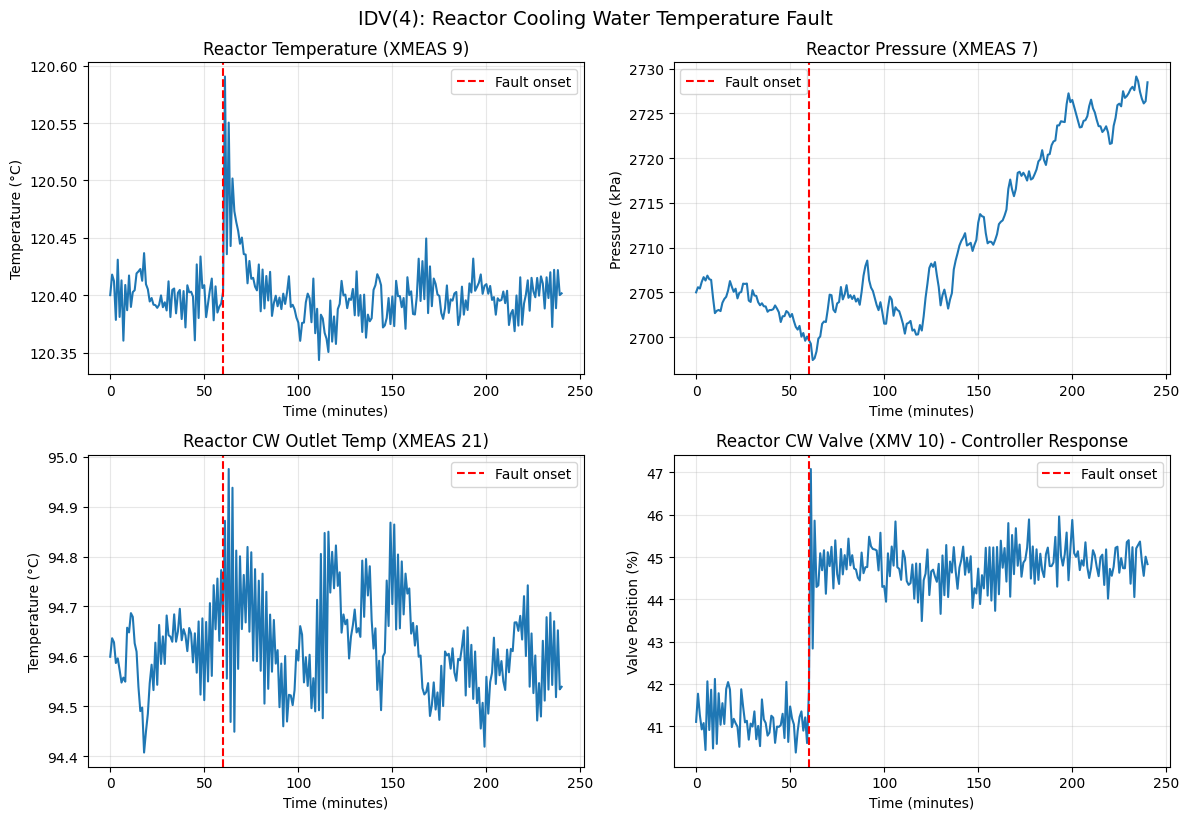

In [8]:
# Plot the most significant measurement changes
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

fault_time = 60  # Fault at 60 minutes

# Reactor temperature - increases significantly with cooling water fault
axes[0, 0].plot(result_fault.time_minutes, result_fault.measurements[:, 8])
axes[0, 0].axvline(x=fault_time, color='r', linestyle='--', label='Fault onset')
axes[0, 0].set_xlabel('Time (minutes)')
axes[0, 0].set_ylabel('Temperature (°C)')
axes[0, 0].set_title('Reactor Temperature (XMEAS 9)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Reactor pressure - rises due to increased temperature
axes[0, 1].plot(result_fault.time_minutes, result_fault.measurements[:, 6])
axes[0, 1].axvline(x=fault_time, color='r', linestyle='--', label='Fault onset')
axes[0, 1].set_xlabel('Time (minutes)')
axes[0, 1].set_ylabel('Pressure (kPa)')
axes[0, 1].set_title('Reactor Pressure (XMEAS 7)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Cooling water outlet temperature - direct indicator of the fault
axes[1, 0].plot(result_fault.time_minutes, result_fault.measurements[:, 20])
axes[1, 0].axvline(x=fault_time, color='r', linestyle='--', label='Fault onset')
axes[1, 0].set_xlabel('Time (minutes)')
axes[1, 0].set_ylabel('Temperature (°C)')
axes[1, 0].set_title('Reactor CW Outlet Temp (XMEAS 21)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Reactor cooling water flow (manipulated variable) - controller response
axes[1, 1].plot(result_fault.time_minutes, result_fault.manipulated_vars[:, 9])
axes[1, 1].axvline(x=fault_time, color='r', linestyle='--', label='Fault onset')
axes[1, 1].set_xlabel('Time (minutes)')
axes[1, 1].set_ylabel('Valve Position (%)')
axes[1, 1].set_title('Reactor CW Valve (XMV 10) - Controller Response')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('IDV(4): Reactor Cooling Water Temperature Fault', y=1.02, fontsize=14)
plt.show()

The plots show the characteristic response to IDV(4):
- **Reactor temperature** increases as the cooling water becomes less effective
- **Reactor pressure** rises due to the increased temperature
- **Cooling water outlet temperature** increases (direct effect of the fault)
- **Cooling water valve** opens further as the controller tries to compensate

## 3. Closed-Loop Control

The simulator includes a decentralized PI control system based on Ricker (1996). Let's compare the process behavior with and without control during a fault.

In [9]:
# Closed-loop simulation (default)
sim_closed = TEPSimulator(random_seed=42, control_mode=ControlMode.CLOSED_LOOP)
sim_closed.initialize()
result_closed = sim_closed.simulate(
    duration_hours=3.0,
    disturbances={1: (0.5, 1)},  # IDV(1) at 30 minutes
    record_interval=60
)

# Open-loop simulation (no control)
sim_open = TEPSimulator(random_seed=42, control_mode=ControlMode.OPEN_LOOP)
sim_open.initialize()
result_open = sim_open.simulate(
    duration_hours=3.0,
    disturbances={1: (0.5, 1)},  # IDV(1) at 30 minutes
    record_interval=60
)

print(f"Closed-loop shutdown: {result_closed.shutdown}")
print(f"Open-loop shutdown:   {result_open.shutdown}")

Closed-loop shutdown: False
Open-loop shutdown:   False


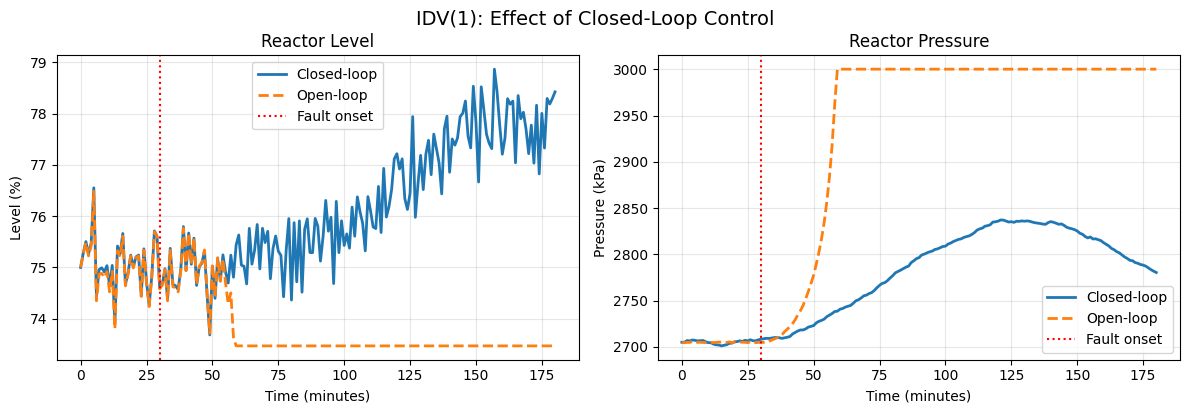

In [10]:
# Compare reactor level with and without control
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

fault_time = 30  # minutes

# Reactor level
axes[0].plot(result_closed.time_minutes, result_closed.measurements[:, 7], 
             label='Closed-loop', linewidth=2)
axes[0].plot(result_open.time_minutes[:len(result_open.measurements)], 
             result_open.measurements[:, 7], 
             label='Open-loop', linewidth=2, linestyle='--')
axes[0].axvline(x=fault_time, color='r', linestyle=':', label='Fault onset')
axes[0].set_xlabel('Time (minutes)')
axes[0].set_ylabel('Level (%)')
axes[0].set_title('Reactor Level')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Reactor pressure
axes[1].plot(result_closed.time_minutes, result_closed.measurements[:, 6], 
             label='Closed-loop', linewidth=2)
axes[1].plot(result_open.time_minutes[:len(result_open.measurements)], 
             result_open.measurements[:, 6], 
             label='Open-loop', linewidth=2, linestyle='--')
axes[1].axvline(x=fault_time, color='r', linestyle=':', label='Fault onset')
axes[1].set_xlabel('Time (minutes)')
axes[1].set_ylabel('Pressure (kPa)')
axes[1].set_title('Reactor Pressure')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('IDV(1): Effect of Closed-Loop Control', y=1.02, fontsize=14)
plt.show()

## 4. Simple Fault Detection

Here we demonstrate a **simple threshold-based detector** for illustration purposes. The idea is straightforward:

1. Establish a baseline mean (μ) and standard deviation (σ) from normal operation
2. Flag a fault when a measurement deviates more than a threshold (e.g., 3σ) from the baseline

**Note:** This is a basic example for illustration only. Real fault detection systems use more sophisticated multivariate methods like PCA, which consider correlations between variables.

In [11]:
# First, run a baseline simulation to establish normal operating statistics
sim = TEPSimulator(random_seed=42, control_mode=ControlMode.CLOSED_LOOP)
sim.initialize()

# Collect baseline data (30 minutes of normal operation)
baseline_result = sim.simulate(duration_hours=0.5, record_interval=10)

# Calculate baseline statistics for reactor temperature (XMEAS 9, index 8)
temp_baseline = baseline_result.measurements[:, 8]
baseline_mean = np.mean(temp_baseline)
baseline_std = np.std(temp_baseline)

# Set detection threshold at 3 sigma
THRESHOLD_SIGMA = 3.0
upper_threshold = baseline_mean + THRESHOLD_SIGMA * baseline_std
lower_threshold = baseline_mean - THRESHOLD_SIGMA * baseline_std

print("Baseline Statistics for Reactor Temperature:")
print(f"  Mean (μ):           {baseline_mean:.2f} °C")
print(f"  Std Dev (σ):        {baseline_std:.4f} °C")
print(f"  Upper Threshold:    {upper_threshold:.2f} °C  (μ + {THRESHOLD_SIGMA}σ)")
print(f"  Lower Threshold:    {lower_threshold:.2f} °C  (μ - {THRESHOLD_SIGMA}σ)")

Baseline Statistics for Reactor Temperature:
  Mean (μ):           120.40 °C
  Std Dev (σ):        0.0166 °C
  Upper Threshold:    120.45 °C  (μ + 3.0σ)
  Lower Threshold:    120.35 °C  (μ - 3.0σ)


In [12]:
# Now simulate with a fault and apply detection
sim = TEPSimulator(random_seed=42, control_mode=ControlMode.CLOSED_LOOP)
sim.initialize()

# Simulate for 2 hours, with fault starting at t=30 minutes
result_detect = sim.simulate(
    duration_hours=2.0,
    disturbances={4: (0.5, 1)},  # IDV(4) at 30 minutes
    record_interval=10
)

# Extract temperature data
times = result_detect.time_minutes
temps = result_detect.measurements[:, 8]

# Simple threshold detection: flag when outside bounds
fault_detected = (temps > upper_threshold) | (temps < lower_threshold)

# Find first detection time after fault onset
fault_onset_idx = np.argmin(np.abs(times - 30))
detection_after_fault = np.where(fault_detected[fault_onset_idx:])[0]
if len(detection_after_fault) > 0:
    first_detection_time = times[fault_onset_idx + detection_after_fault[0]]
    detection_delay = first_detection_time - 30
    print(f"First detection after fault: {first_detection_time:.1f} minutes")
    print(f"Detection delay: {detection_delay:.1f} minutes")
else:
    print("Fault not detected by this simple method")

First detection after fault: 30.5 minutes
Detection delay: 0.5 minutes


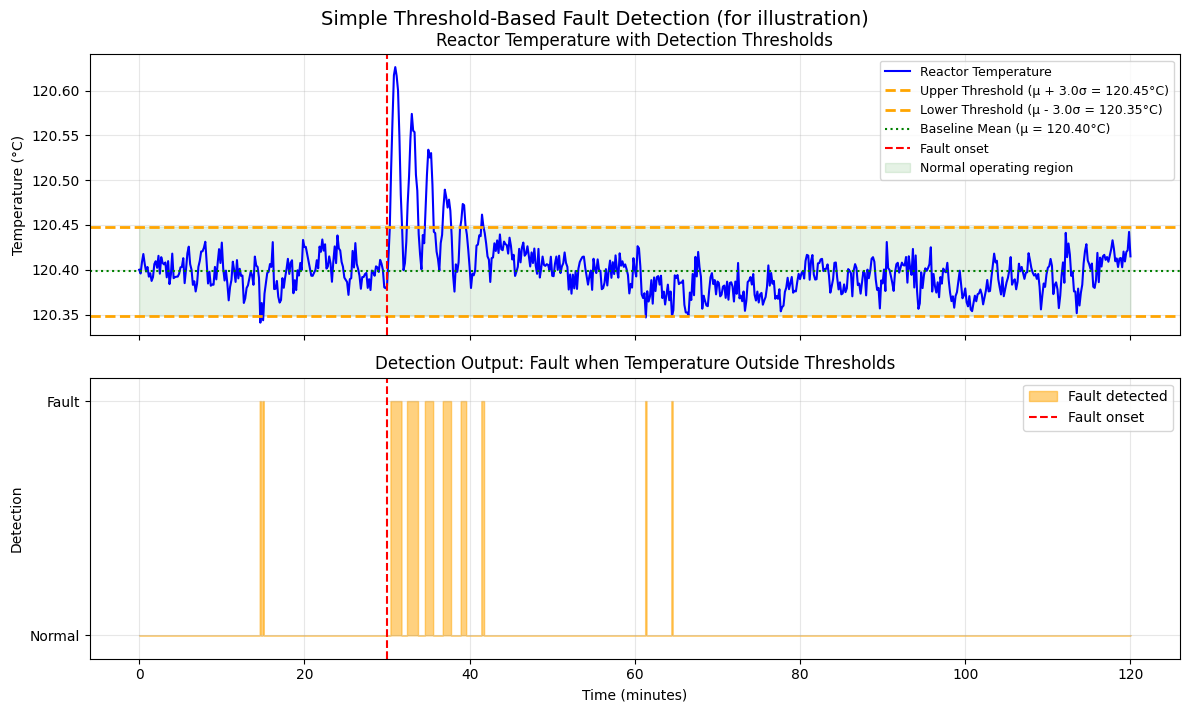

In [13]:
# Plot temperature with threshold lines
fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

fault_time = 30  # minutes

# Temperature with thresholds
axes[0].plot(times, temps, 'b-', linewidth=1.5, label='Reactor Temperature')
axes[0].axhline(y=upper_threshold, color='orange', linestyle='--', linewidth=2, 
                label=f'Upper Threshold (μ + {THRESHOLD_SIGMA}σ = {upper_threshold:.2f}°C)')
axes[0].axhline(y=lower_threshold, color='orange', linestyle='--', linewidth=2,
                label=f'Lower Threshold (μ - {THRESHOLD_SIGMA}σ = {lower_threshold:.2f}°C)')
axes[0].axhline(y=baseline_mean, color='green', linestyle=':', linewidth=1.5,
                label=f'Baseline Mean (μ = {baseline_mean:.2f}°C)')
axes[0].axvline(x=fault_time, color='r', linestyle='--', linewidth=1.5, label='Fault onset')
axes[0].fill_between(times, lower_threshold, upper_threshold, alpha=0.1, color='green', 
                     label='Normal operating region')
axes[0].set_ylabel('Temperature (°C)')
axes[0].set_title('Reactor Temperature with Detection Thresholds')
axes[0].legend(loc='upper right', fontsize=9)
axes[0].grid(True, alpha=0.3)

# Detection signal
axes[1].fill_between(times, 0, fault_detected.astype(int), alpha=0.5, color='orange', 
                     label='Fault detected', step='mid')
axes[1].axvline(x=fault_time, color='r', linestyle='--', linewidth=1.5, label='Fault onset')
axes[1].set_xlabel('Time (minutes)')
axes[1].set_ylabel('Detection')
axes[1].set_title('Detection Output: Fault when Temperature Outside Thresholds')
axes[1].set_ylim(-0.1, 1.1)
axes[1].set_yticks([0, 1])
axes[1].set_yticklabels(['Normal', 'Fault'])
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Simple Threshold-Based Fault Detection (for illustration)', y=1.01, fontsize=14)
plt.show()

In [14]:
# Calculate simple detection metrics
# Ground truth: fault starts at 30 minutes
ground_truth = times >= 30

# Metrics
true_positives = np.sum(fault_detected & ground_truth)
false_positives = np.sum(fault_detected & ~ground_truth)
true_negatives = np.sum(~fault_detected & ~ground_truth)
false_negatives = np.sum(~fault_detected & ground_truth)

accuracy = (true_positives + true_negatives) / len(times)
detection_rate = true_positives / np.sum(ground_truth) if np.sum(ground_truth) > 0 else 0
false_alarm_rate = false_positives / np.sum(~ground_truth) if np.sum(~ground_truth) > 0 else 0

print("Simple Threshold Detection Metrics:")
print("=" * 40)
print(f"  Threshold:            ±{THRESHOLD_SIGMA}σ from baseline mean")
print(f"  Total samples:        {len(times)}")
print(f"  True Positives:       {true_positives}")
print(f"  False Positives:      {false_positives}")
print(f"  Accuracy:             {accuracy:.3f}")
print(f"  Fault Detection Rate: {detection_rate:.3f}")
print(f"  False Alarm Rate:     {false_alarm_rate:.3f}")

Simple Threshold Detection Metrics:
  Threshold:            ±3.0σ from baseline mean
  Total samples:        721
  True Positives:       36
  False Positives:      2
  Accuracy:             0.298
  Fault Detection Rate: 0.067
  False Alarm Rate:     0.011


## Summary

This notebook demonstrated the basic usage of the Tennessee Eastman Process simulator:

1. **Basic simulation** - Running fault-free simulations and accessing measurements
2. **Fault injection** - Applying process disturbances and observing their effects
3. **Control modes** - Comparing open-loop vs closed-loop behavior
4. **Fault detection** - Using built-in detectors to identify abnormal conditions

For more advanced usage, see the other examples in the `examples/` directory:
- `fault_detection.py` - Comprehensive fault detection examples
- `custom_controller.py` - Implementing custom control strategies
- `data_generation.py` - Generating datasets for machine learning
- `rieth2017_dataset.py` - Working with the Rieth 2017 benchmark dataset